In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

notebookname = "Drug_Data_"
variant = "LSTM_w_stopwords_"
version = "1.0_"
title = notebookname + variant + version
print (title)

#Data Source Citation:
#Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link]

Drug_Data_LSTM_w_stopwords_1.0_


# Import the libraries


In [0]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import h5py
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from keras.models import Model, Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from tqdm import tqdm

%matplotlib inline


In [0]:
nltk.download('stopwords')

drug_stopwords = pd.read_csv('drugname_stopwords.csv')
drug_stopwords = drug_stopwords["0"].tolist()
print(drug_stopwords)

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 3000
EMBEDDING_DIM = 160

# max_words = 3500
# max_len = 180
# embedding_vector_length = 160


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['acetaminophen', 'pseudoephedrine', 'phenylephrine', 'estradiol', 'dextromethorphan', 'codeine', 'hydrochlorothiazide', 'chlorpheniramine', 'guaifenesin', 'metformin', 'ethinyl', 'mucinex', 'hydrocortisone', 'peroxide', 'amlodipine', 'diphenhydramine', 'tylenol', 'tenofovir', 'polymyxin', 'dha', 'hfa', 'benzoyl', 'advil', 'vicks', 'butalbital', 'loestrin', 'emtricitabine', 'lidocaine', 'salicylate', 'salicylic', 'odt', 'naproxen', 'claritin', 'senna', 'hyoscyamine', 'sudafed', 'estrogens', 'valsartan', 'brompheniramine', 'dexamethasone', 'gildess', 'intensol', 'hct', 'junel', 'afrin', 'globulin', 'neomycin', 'simethicone', 'excedrin', 'methenamine', 'depo', 'promethazine', 'microgestin', 'nizoral', 'monistat', 'naloxone', 'respimat', 'norethindrone', 'pyrilamine', 'ellipta', 'atropine', 'olmesartan', 'lamivudine', 'hydroxide', 'oxycodone', 'provera', 'fluticasone', 'l

# Read in data

In [0]:
# Uncomment for first run.
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
#!unzip drugsCom_raw.zip

train_df = pd.read_table('drugsComTrain_raw.tsv')
test_df = pd.read_table('drugsComTest_raw.tsv')


In [0]:
def rank_bin(array):
  y_rank = []
  for i in array:
    if i <= 4: # Negative Rating Cut Off (Inclusive)
      y_rank.append('Negative')
    elif i >= 7: # Positive Rating Cut Off (Inclusive)
      y_rank.append('Positive')
    else:
      y_rank.append('Neutral')
  return y_rank

# Assign test & train data their classes.
train_df['classes_to_predict'] = rank_bin(train_df['rating'])
test_df['classes_to_predict'] = rank_bin(test_df['rating'])

# Make a variable to contain the class labels.
classes_to_predict = ['Positive','Negative','Neutral']

## Rating to good/bad



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


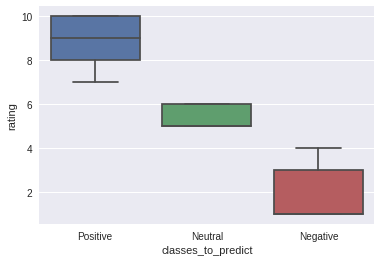

In [0]:
# Show the coverage for each group by its rating.
sns.boxplot(x='classes_to_predict', y="rating", data=train_df)
plt.show()

In [0]:
train_df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,classes_to_predict
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,Positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,Neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,Positive


## Preprocess the text data


In [0]:
print('performing some basic preprocessing on data')

# Regex for removing non-alphanumeric characters and spaces
remove_special_char = re.compile('r[^a-z\d]',re.IGNORECASE)

# Regex to replace all numerics
replace_numerics = re.compile(r'\d+',re.IGNORECASE)

# Load NLTK stop words
stop_words = nltk.corpus.stopwords.words('english')
print ("NLTK stopword list length: ",len(stop_words),'words')

# Add custom drug stopwords
stop_words.extend(drug_stopwords)
print ("Added custom stopwords")
print ("New stopword list length: ",len(stop_words),'words')

# Define Text-PreProcessing function
def preprocess_text(text, remove_stopwords = True, perform_stemming = True):
    #first clean text then go to lowercase and split.
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"(\d)", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"@", "at")
    text = text.lower().split()
    
    #stopword removal (nltk + custom drug stopwords)
    if(remove_stopwords):
        text = [word for word in text if word not in stop_words]
     
    text = ' '.join(text)   #This is the only portion I'm uncertain of...
    
    text = remove_special_char.sub('', text)
    text = replace_numerics.sub('n', text)
        
    if(perform_stemming):
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = ' '.join(stemmed_words)
        
    return text    


performing some basic preprocessing on data
NLTK stopword list length:  179 words
Added custom stopwords
New stopword list length:  3057 words


In [0]:
# Clean text
raw_train_comments = train_df['review'].fillna('NA').values
raw_test_comments = test_df['review'].fillna('NA').values

# Define y for Training/Validation 
y = pd.get_dummies(train_df['classes_to_predict']).values
np.savetxt("y_train2.csv", y, delimiter=",", fmt='%s')
# Define y for Tests
y_test_predicted = pd.get_dummies(test_df['classes_to_predict']).values
np.savetxt("y_test2.csv", y_test_predicted, delimiter=",", fmt='%s')

print ('Raw comments: \n',raw_train_comments[1:5])

# Process reviews for Training (X)
processed_train_comments = []
for comment in tqdm(raw_train_comments):
    processed_train_comments.append(preprocess_text(comment))

np.savetxt("processed_train_comments2.csv", processed_train_comments, delimiter=",", fmt='%s')

# Process reviews for Testing (X)
processed_test_comments = []    
for comment in tqdm(raw_test_comments):
    processed_test_comments.append(preprocess_text(comment))

np.savetxt("processed_test_comments2.csv", processed_test_comments, delimiter=",", fmt='%s')
    
print ('Processed comments: \n',processed_train_comments[1:5])

  0%|          | 17/161297 [00:00<16:42, 160.94it/s]

Raw comments: 
 ['"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'
 '"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, 

100%|██████████| 53766/53766 [05:36<00:00, 159.99it/s]


Processed comments: 
 ['"mi son halfway fourth week intuniv. becam concern began last week, start take highest dose on. two days, could hard get bed, cranky, slept near n hour drive home school vacat (veri unusu him.) call doctomonday morn said stick days. see school, get morning. last two day problem free. much agreeabl eve less emot (a good thing), less cranky. rememb thing should. overal behaviobett tri mani differ medic faeffective."', '"i use take anotheor contraceptive, n pill cycle, happy- light periods, max n days, side effects. contain hormon gestodene, avail us, switch lybrel, ingredi simila pill ended, start immediately, first day period, instruct said. period last two weeks. take second pack- two weeks. now, third pack thing got even worse- third period last two week it&#n; end third week- still daili brown discharge. posit side didn&#n;t side effects. idea period free tempting... alas."', '"this first time use form birth control. i&#n;m glad went patch, n months. first dec

In [0]:
print (y)

[[0 0 1]
 [0 0 1]
 [0 1 0]
 ...
 [1 0 0]
 [0 0 1]
 [0 0 1]]


In [0]:
# Refresh auth if needed
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Save Model & Run Data 

uploaded = drive.CreateFile({'title': "{}processed_train_comments2.csv".format(title)})
uploaded.SetContentFile("processed_train_comments2.csv")
uploaded.Upload()
print('Uploaded file processed_train_comments2.csv with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': '{}processed_test_comments2.csv'.format(title)})
uploaded.SetContentFile('processed_test_comments2.csv')
uploaded.Upload()
print('Uploaded file processed_test_comments2.csv with ID {}'.format(uploaded.get('id')))

Uploaded file processed_train_comments2.csv with ID 1Zs3OSKTuQa_E4HF_38HKCokPjQ0V5j83
Uploaded file processed_test_comments2.csv with ID 1qF0_JZyuFWGdp1rgS4_j0l6RRKyr__7Y


In [0]:
#reload processed train comments 
#processed_train_comments = [line.strip() for line in open("processed_train_comments2.csv", 'r')]
#len(processed_train_comments)

161297

In [0]:
train_df_iq = pd.DataFrame(y)
train_df_iq[3] = processed_train_comments
train_df_iq.head()

,0,1,2,3
0,0,0,1,"""it side effect, take combin n mg fish oil"""
1,0,0,1,"""mi son halfway fourth week intuniv. becam con..."
2,0,1,0,"""i use take anotheor contraceptive, n pill cyc..."
3,0,0,1,"""this first time use form birth control. i&#n;..."
4,0,0,1,"""suboxon complet turn life around. feel health..."


43.21011550121825
975


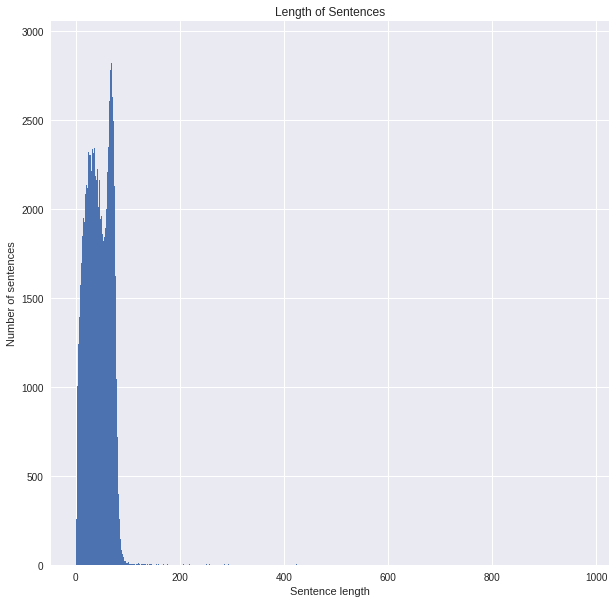

In [0]:
train_df_iq = pd.DataFrame(y)
train_df_iq[3] = processed_train_comments

print(train_df_iq[3].str.split().str.len().mean())
print(train_df_iq[3].str.split().str.len().max())
train_df_iq["strlen"] = train_df_iq[3].str.split().str.len()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences')
plt.hist(train_df_iq["strlen"], bins=975)
plt.show()

In [0]:
train_df_iq.describe()

,0,1,2,strlen
count,161297.000000,161297.000000,161297.000000,161297.000000
mean,0.248455,0.089004,0.662542,43.210116
std,0.432118,0.284750,0.472844,22.724157
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,25.000000
50%,0.000000,0.000000,1.000000,43.000000
75%,0.000000,0.000000,1.000000,63.000000
max,1.000000,1.000000,1.000000,975.000000


In [0]:
_a = train_df_iq.loc[train_df_iq["strlen"] >= 1000].strlen.count()
_b = train_df_iq.loc[train_df_iq["strlen"] >= 750].strlen.count()
_c = train_df_iq.loc[train_df_iq["strlen"] >= 250].strlen.count()
_d = train_df_iq.loc[train_df_iq["strlen"] >= 180].strlen.count()
_e = train_df_iq.loc[train_df_iq["strlen"] >= 100].strlen.count()
_f = train_df_iq.loc[train_df_iq["strlen"] < 100].strlen.count()
print (" # of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 0 >1000 words 
 1 >750 words 
 30 >250 words 
 64 >180 words 
 274 >100 words 
 161023 <100 words



New word count mean: 43.00540896360283
New word count max: 100


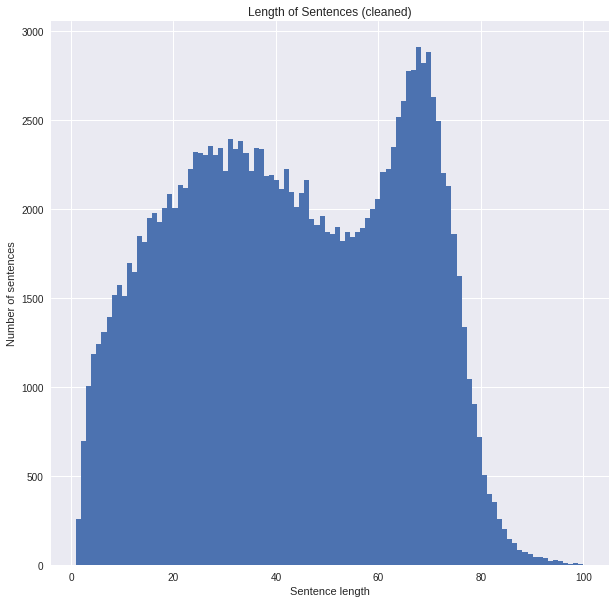

In [0]:
# Drop long rows
train_df_iq = train_df_iq.loc[train_df_iq["strlen"] <= MAX_SEQUENCE_LENGTH]

print("New word count mean:", train_df_iq[3].str.split().str.len().mean())
print("New word count max:",train_df_iq[3].str.split().str.len().max())
train_df_iq.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences (cleaned)')
plt.hist(train_df_iq["strlen"], bins=MAX_SEQUENCE_LENGTH)
plt.show()

# Drop unwanted columns


In [0]:
post_processed_train_comments = train_df_iq[3].tolist()
post_processed_y = train_df_iq[[0, 1, 2]].values.tolist()

print('y: \n',y[0:5])
print('post_y: \n',post_processed_y[0:5])

print('pre_train comments: \n',processed_train_comments[0:5])
print('post_train comments: \n',post_processed_train_comments[0:5])

print('y_test:\n',y_test_predicted[0:5])
print('x_test:\n',processed_test_comments[0:5])

In [0]:
post_processed_train_comments[0:50]

## Create vector with features and vector with encoded label


In [0]:
# MAX_NB_WORDS is set at top
# MAX_SEQUENCE_LENGTH is set at top. 

# Tokenize the data
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(post_processed_train_comments + processed_test_comments)

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(post_processed_train_comments)
test_sequences = tokenizer.texts_to_sequences(processed_test_comments)
print('found %s tokens in text.' %(tokenizer.word_index))

# Ensure all sequences have the same length. 
train_data = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
final_test_data = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

# Print shapes of data. 
word_index = tokenizer.word_index
print(train_data.shape, '<-- shape of train_data ready for val/train split.')
print(final_test_data.shape, '<-- shape of final_test_data ready for fedding to network.')
print(len(word_index), '<-- Length of Word Index')

found {'n': 1, 'i': 2, 't': 3, 'take': 4, 'day': 5, 'it': 6, 'month': 7, 'get': 8, 'm': 9, 'start': 10, 'work': 11, 'side': 12, 'pain': 13, 'feel': 14, 'week': 15, 'v': 16, 'time': 17, 'effect': 18, 'first': 19, 'like': 20, 'use': 21, 'pill': 22, 'period': 23, 'tri': 24, 'go': 25, 'would': 26, 'help': 27, 'year': 28, 'one': 29, 'back': 30, 'nmg': 31, 'also': 32, 'took': 33, 'weight': 34, 'got': 35, 'life': 36, 'me': 37, 'don': 38, 'bad': 39, 'still': 40, 'medic': 41, 'much': 42, 'realli': 43, 'stop': 44, 'control': 45, 'sinc': 46, 'last': 47, 'went': 48, 'sleep': 49, 'two': 50, 'quot': 51, 'night': 52, 'gain': 53, 'well': 54, 'great': 55, 'sever': 56, 'even': 57, 'everi': 58, 'didn': 59, 'felt': 60, 'good': 61, 'medicin': 62, 'make': 63, 'drug': 64, 'ago': 65, 'effects': 66, 'birth': 67, 'thing': 68, 'dose': 69, 'this': 70, 'mg': 71, 'made': 72, 'anxieti': 73, 'littl': 74, 'years': 75, 'almost': 76, 'could': 77, 'now': 78, 'think': 79, 'lot': 80, 'want': 81, 'notic': 82, 'put': 83, 'de

## Train/Validation split

In [0]:
# Split Training & Validation Data
print('creating train and validation data by dividing train_data in 80:20 ratio')
######################################################

X_train, X_val, Y_train, Y_val = train_test_split(train_data, post_processed_y,
                                                  test_size = 0.2,  stratify= post_processed_y, 
                                                  random_state = 2018)
X_test = final_test_data
Y_test = y_test_predicted

######################################################
print('train data shape:', X_train.shape)
print('validation data shape:', X_val.shape)
print('Data is ready for training!!')

creating train and validation data by dividing train_data in 80:20 ratio
train data shape: (128823, 100)
validation data shape: (32206, 100)
Data is ready for training!!


## Set up model


In [0]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = MAX_SEQUENCE_LENGTH

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(50))
#model.add(Attention(MAX_SEQUENCE_LENGTH))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                42200     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153       
Total params: 522,353
Trainable params: 522,353
Non-trainable params: 0
_________________________________________________________________


## Fit on dataset


In [0]:
training_cycle = 1
batch = 32 
stamp = '{}trainging_cycle{}batchsize_{}'.format(title,training_cycle,batch)
print(stamp)

Drug_Data_LSTM_w_stopwords_1.0_trainging_cycle1batchsize_32


In [0]:
training_cycle = 1
batch = 32 

stamp = '{}trainging_cycle{}batchsize_{}'.format(title,training_cycle,batch)
print(stamp)
best_model_path = stamp + '.h5'

early_stopping = EarlyStopping(patience = 3)
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only = True)


# Run LSTM Model
epoch = 30
LSTM_model = model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,
                       validation_data=(X_val, Y_val), shuffle = True, 
                       callbacks = [early_stopping, model_checkpoint])
best_score = min(LSTM_model.history['val_loss'])


# Save Training History
df_fit = pd.DataFrame(columns=['loss','acc','val_loss','val_acc'])
df_fit['loss'] = LSTM_model.history['loss']
df_fit['val_loss'] = LSTM_model.history['val_loss']
df_fit['acc'] = LSTM_model.history['acc']
df_fit['val_acc'] = LSTM_model.history['val_acc']
df_fit

# Save Model & Run Data 
save_name = ('DrugDataLSTM_batch_{}_epoch_{}_cycle_{}'.format(batch,epoch,training_cycle))

uploaded = drive.CreateFile({'title': '{}.h5'.format(save_name)})
model.save('{}.h5'.format(save_name))
uploaded.SetContentFile('{}.h5'.format(save_name))
uploaded.Upload()
print('Uploaded file {}.h5'.format(save_name),'with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': '{}.csv'.format(save_name)})
df_fit.to_csv('{}.csv'.format(save_name))
uploaded.SetContentFile('{}.csv'.format(save_name))
uploaded.Upload()
print('Uploaded file {}.csv'.format(save_name),'with ID {}'.format(uploaded.get('id')))

# initial param batch=32, epoch=10

#Epoch 5/5 (256 batch size)
#102455/102455 [==============================] - 286s 3ms/step - loss: 0.2414 - acc: 0.8999 - val_loss: 0.3141 - val_acc: 0.8696

'''
Epoch 1-5 Batch size 64
Train on 102455 samples, validate on 25614 samples
102455/102455 [==============================] - 416s 4ms/step - loss: 0.2463 - acc: 0.8982 - val_loss: 0.3142 - val_acc: 0.8693'''

#sentiment_with_lstm_1.00_8.00
#Train on 102455 samples, validate on 25614 samples
#Epoch 1/30
#102455/102455 [==============================] - 1808s 18ms/step - loss: 0.1472 - acc: 0.9429 - val_loss: 0.3224 - val_acc: 0.8833

Drug_Data_LSTM_w_stopwords_1.0_trainging_cycle1batchsize_32


ValueError: ignored

In [0]:
training_cycle = 1
batch = 16 
epoch = 6
# Save Training History
df_fit = pd.DataFrame(columns=['loss','acc','val_loss','val_acc'])
df_fit['loss'] = LSTM_model.history['loss']
df_fit['val_loss'] = LSTM_model.history['val_loss']
df_fit['acc'] = LSTM_model.history['acc']
df_fit['val_acc'] = LSTM_model.history['val_acc']
df_fit

# Save Model & Run Data 
save_name = ('DrugDataLSTM_batch_{}_epoch_{}_cycle_{}'.format(batch,epoch,training_cycle))

uploaded = drive.CreateFile({'title': '{}.h5'.format(save_name)})
model.save('{}.h5'.format(save_name))
uploaded.SetContentFile('{}.h5'.format(save_name))
uploaded.Upload()
print('Uploaded file {}.h5'.format(save_name),'with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': '{}.csv'.format(save_name)})
df_fit.to_csv('{}.csv'.format(save_name))
uploaded.SetContentFile('{}.csv'.format(save_name))
uploaded.Upload()
print('Uploaded file {}.csv'.format(save_name),'with ID {}'.format(uploaded.get('id')))

Uploaded file DrugDataLSTM_batch_16_epoch_6_cycle_1.h5 with ID 10fTFluG_5URGQs_qPqsD7mDBEAJN2tKd
Uploaded file DrugDataLSTM_batch_16_epoch_6_cycle_1.csv with ID 1_WG-3GOrZMWvrITHQbbO-CpzSmjKJy4p


In [0]:
print('DrugDataLSTM_batch_{}_epoch_{}_cycle_{}'.format(batch,epoch,training_cycle))

DrugDataLSTM_batch_16_epoch_6_cycle_1


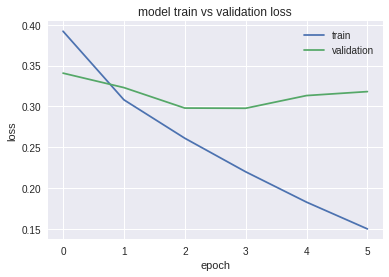

In [0]:
# Plot training vs validation loss over epoch. 

plt.plot(LSTM_model.history['loss'])
plt.plot(LSTM_model.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
# Save fit run history to dataframe. 
df_fit = pd.DataFrame(columns=['loss','acc','val_loss','val_acc'])

df_fit['loss'] = LSTM_model.history['loss']
df_fit['val_loss'] = LSTM_model.history['val_loss']
df_fit['acc'] = LSTM_model.history['acc']
df_fit['val_acc'] = LSTM_model.history['val_acc']
df_fit

,loss,acc,val_loss,val_acc
0,0.421998,0.808111,0.365484,0.842313
1,0.345942,0.850539,0.351401,0.847466
2,0.321146,0.861627,0.340565,0.851097
3,0.296456,0.872246,0.335464,0.855860
4,0.275704,0.883129,0.330628,0.861990
5,0.252300,0.894422,0.328474,0.864371
6,0.230759,0.905217,0.329156,0.868080
7,0.210392,0.914333,0.335412,0.869056
8,0.192135,0.923078,0.341423,0.870579
9,0.173394,0.931912,0.353553,0.872765


# Adjust validation data en fit to data


In [0]:
accr = model.evaluate(X_test,Y_test, batch_size = 256)

85380/85380 [==============================] - 76s 889us/step


# Check against test data

In [0]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.996
  Accuracy: 0.889


In [0]:
#test_sequences = tok.texts_to_sequences(X_test)
#test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

prediction = model.predict(X_test)


In [0]:
target_names = ['Bad', 'Good']
print(confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1)))

[[20923  4593]
 [ 4883 54981]]


In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    #plt.ylabel('True label', fontsize=30)
    #plt.xlabel('Predicted label', fontsize=30)

    return plt

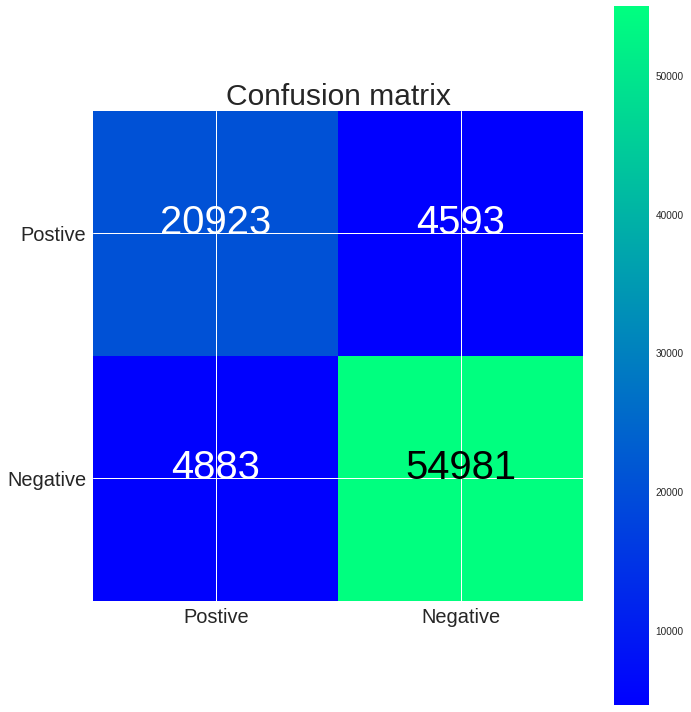

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [1 0]]


In [0]:
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Postive','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print(Y_test)

### Notes: This network performed worse in terms of loss, accuracy, and time to train.


In [0]:
# Download a file from Google Drive
#downloaded = drive.CreateFile({'id': "1-wo8jSg_vG76oXN8oMh9cICeuCYxGr8v"})
#downloaded.GetContentFile("batch_64_epoch_6_10_trained.h5")

In [0]:
# Reload the saved model. 
#model = load_model('batch_64_epoch_6_10_trained.h5')